# Multiple ancilla qubit simulation for time dependent TFIM model

References:
- Zhiyan Ding, Chi-Fang Chen and Lin Lin:
  [Single-ancilla ground state preparation via Lindbladians](https://arxiv.org/abs/2308.15676)

- Zhiyan Ding and Xiantao Li and Lin Lin:
  [Simulating Open Quantum Systems Using Hamiltonian Simulations](https://arxiv.org/abs/2311.15533)

## TFIM damping model, time independent Hamiltonian

In [1]:
import matplotlib.pyplot as plt
import qsimulations as qs
import numpy as np
from qutip import *

In [2]:
taylor_aprox_order = (
    8  # Taylor approximation used for simulating exp(-i*sqrt*(dt)*H_tilde)
)

systemSize = 1  # System Hamiltonian
nrAncillas = 1  # Ancilla size
nrOfDampingOps = 2
J = 2  # Nr of jump operators is equal to the number of lattice elements
systemSize_dim = np.power(2, systemSize)  # Hamiltonian system size


T = 10 * np.pi  # Final time
dt = 0.001  # Time step
time_vec = np.arange(0, T, dt)  # Time vector to simulate on


def H_operator(t):
    H = -(np.sqrt(2) / 2) * (1 - np.cos(t)) * qs.Z
    return Qobj(H)


def H_operator_derivative(t):
    H = -(np.sqrt(2) / 2) * np.sin(t) * qs.Z
    return Qobj(H)


def V_damping(i, t):
    if i == 0:
        sum = 0
        for j in np.arange(1, J + 1, 1):
            sum = sum + V_damping(j, t).full().conj().T @ V_damping(j, t).full()
        return Qobj(-1j * H_operator(t).full() - 0.5 * sum)
    elif i == 1:
        return Qobj((2 + 0.5 * np.sin(t)) * qs.creation_op)
    elif i == 2:
        return Qobj((3 - 0.5 * np.sin(t)) * qs.annihilation_op)
    else:
        return 0


def V_damping_derivative(i, t):
    if i == 1:
        return Qobj((0.5 * np.cos(t)) * qs.creation_op)
    elif i == 2:
        return Qobj((-0.5 * np.cos(t)) * qs.annihilation_op)
    else:
        return 0


QSystem = qs.qsimulations(systemSize, systemSize, nrAncillas)
QSystem.H_op = H_operator
QSystem.V_op = V_damping
QSystem.H_op_derivative = H_operator_derivative
QSystem.V_op_derivative = V_damping_derivative
QSystem.set_nr_of_damping_ops(J)
QSystem._update_module_varibles()
QSystem._prep_energy_states()

rho_ground = QSystem.rho_ground
rho_highest_en = QSystem.rho_highest_en

starting_state = rho_ground
mesurement_op = qs.Z

### Exact simulation


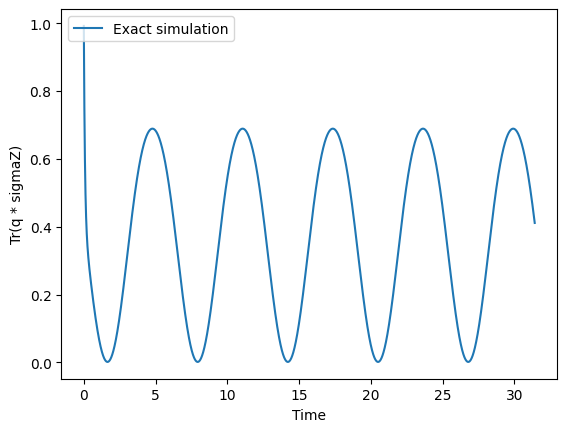

In [3]:
import matplotlib.pyplot as plt
from qutip import mesolve
import numpy as np

rho = starting_state
exact_trace = []
for t in time_vec:
    sum = 0
    for j in np.arange(1, J + 1, 1):
        sum = (
            sum
            + QSystem.V_op(j, t) @ rho @ QSystem.V_op(j, t).conj().trans()
            - 0.5
            * (
                QSystem.V_op(j, t).conj().trans() @ QSystem.V_op(j, t) @ rho
                + rho @ QSystem.V_op(j, t).conj().trans() @ QSystem.V_op(j, t)
            )
        )

    delta_rho = -1j * (QSystem.H_op(t) @ rho - rho @ QSystem.H_op(t)) + sum
    rho = rho + dt * delta_rho
    exact_trace.append((rho @ mesurement_op).tr())

plt.figure()
plt.xlabel("Time")
plt.ylabel("Tr(q * sigmaZ)")
plt.plot(time_vec, exact_trace, label="Exact simulation")
plt.legend(loc="upper left")

### First order approximation

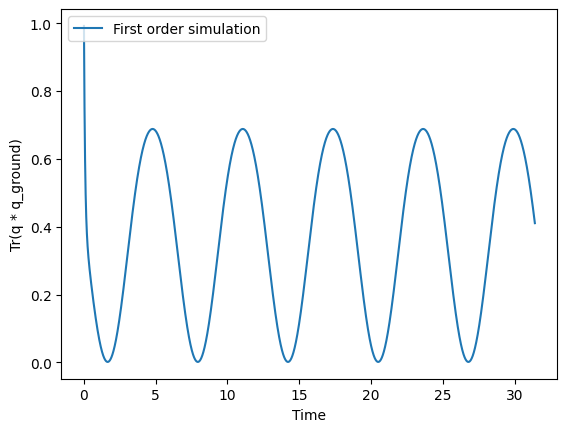

In [4]:
import math
import numpy as np

ancilla = 2  # Ancillary system size
QSystem.set_nr_of_ancillas(ancilla)
ancilla_dim = np.power(2, ancilla)
total_systemSize = systemSize + ancilla  # Total system size
total_systemSize_dim = np.power(2, total_systemSize)
taylor_aproximation_order = 10

# First order scheme
psi_ancilla = 1
for i in range(ancilla):
    psi_ancilla = np.kron(psi_ancilla, qs.ket_0)
rho_ancilla = Qobj(psi_ancilla.conj().T @ psi_ancilla)

rho = starting_state
first_order_trace = []
for t in time_vec:
    # Extended system, zero initialized ancilla + hamiltonian system
    system = Qobj(
        tensor(rho_ancilla, rho),
        dims=[[ancilla_dim, systemSize_dim], [ancilla_dim, systemSize_dim]],
    )
    # First element of taylor approximation, I
    approximation = Qobj(
        qeye(ancilla_dim * systemSize_dim),
        dims=[[ancilla_dim, systemSize_dim], [ancilla_dim, systemSize_dim]],
    )

    approximation = qs.Taylor_approximtion(
        QSystem.H_tilde_first_order(dt, t),
        taylor_aproximation_order,
        np.sqrt(dt),
        approximation,
    )
    evolved_system = approximation @ system @ approximation.conj().trans()

    rho = evolved_system.ptrace(1)
    first_order_trace.append((rho @ mesurement_op).tr())

plt.figure()
plt.xlabel("Time")
plt.ylabel("Tr(q * q_ground)")
plt.plot(time_vec, first_order_trace, label="First order simulation")
plt.legend(loc="upper left")

### Second order approximation

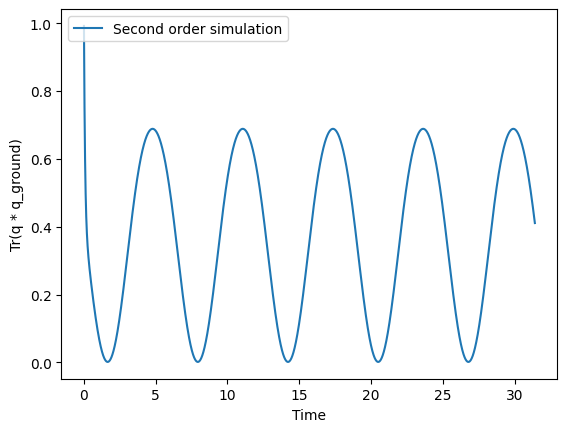

In [5]:
import math
import numpy as np

ancilla = 5  # Ancillary system size
QSystem.set_nr_of_ancillas(ancilla)
ancilla_dim = np.power(2, ancilla)
total_systemSize = systemSize + ancilla  # Total system size
total_systemSize_dim = np.power(2, total_systemSize)
taylor_aproximation_order = 10

# First order scheme
psi_ancilla = 1
for i in range(ancilla):
    psi_ancilla = np.kron(psi_ancilla, qs.ket_0)
rho_ancilla = Qobj(psi_ancilla.conj().T @ psi_ancilla)

rho = starting_state
second_order_trace = []
for t in time_vec:
    # Extended system, zero initialized ancilla + hamiltonian system
    system = Qobj(
        tensor(rho_ancilla, rho),
        dims=[[ancilla_dim, systemSize_dim], [ancilla_dim, systemSize_dim]],
    )
    # First element of taylor approximation, I
    approximation = Qobj(
        qeye(ancilla_dim * systemSize_dim),
        dims=[[ancilla_dim, systemSize_dim], [ancilla_dim, systemSize_dim]],
    )

    approximation = qs.Taylor_approximtion(
        QSystem.H_tilde_second_order(dt, t),
        taylor_aproximation_order,
        np.sqrt(dt),
        approximation,
    )
    evolved_system = approximation @ system @ approximation.conj().trans()

    rho = evolved_system.ptrace(1)
    second_order_trace.append((rho @ mesurement_op).tr())

plt.figure()
plt.xlabel("Time")
plt.ylabel("Tr(q * q_ground)")
plt.plot(time_vec, second_order_trace, label="Second order simulation")
plt.legend(loc="upper left")

314


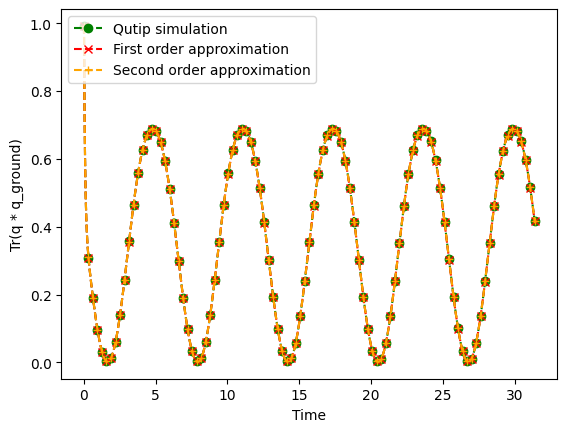

In [7]:
import matplotlib.pyplot as plt

total_nr_of_points = 100
plot_density = (int)(np.size(time_vec) / total_nr_of_points)
print(plot_density)

plt.figure()
plt.xlabel("Time")
plt.ylabel("Tr(q * q_ground)")
# plt.plot(time_vec, exact_trace_rho_highest_en, label="Exact simulation")
plt.plot(
    time_vec,
    exact_trace,
    label="Qutip simulation",
    color="green",
    marker="o",
    linestyle="dashed",
    markevery=plot_density,
)
plt.plot(
    time_vec,
    first_order_trace,
    label="First order approximation",
    color="red",
    marker="x",
    linestyle="dashed",
    markevery=plot_density,
)
plt.plot(
    time_vec,
    second_order_trace,
    label="Second order approximation",
    color="orange",
    marker="+",
    linestyle="dashed",
    markevery=plot_density,
)
plt.legend(loc="upper left")